In [1]:
import cv2
import math
import copy
import numpy as np
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters

In [70]:
def ImportImg(template, frame_i, frame_f, laserline_num): # import images
    # image parameters (for cutting)
    top    = 2592
    bottom = 0
    left   = 0
    right  = 3872
    # import template frame
    img_template = cv2.imread(template,0)
    # create list for storing frame information
    img_out = np.linspace([],[],laserline_num).tolist()
    for i in range(frame_i,frame_f+1):
        img_out[i-frame_i] = cv2.subtract(cv2.imread('DSC_'+str(i)+'.JPG',0), img_template) # subtrction reduce noise
        img_out[i-frame_i] = img_out[i-frame_i][bottom:top,left:right] # crop image
        img_out[i-frame_i] = cv2.blur(img_out[i-frame_i], [10,10])      # blur image
#     plt.imshow(img_out[1], cmap = 'gray') # image check
#     plt.show()
    return img_out


def OverLay(img): # ovrelay images
    fullmap = img[0]
    for i in range(len(img)-1):
        aggregate_img = fullmap
        next_img = img[i+1]
        fullmap = cv2.addWeighted(aggregate_img, 1, next_img, 1, 0)
#     plt.imshow(fullmap, cmap = 'gray')
#     plt.show()
    return fullmap


def TiltCorrect(curve_fit): # correct for tilting due to camera 
    avg = np.linspace(np.mean(curve_fit[-1]),np.mean(curve_fit[-1]),np.shape(curve_fit)[1])
    error = np.subtract(avg,curve_fit[-1])
    for i in range(np.shape(curve_fit)[0]):
        curve_fit[i] = np.add(curve_fit[i],error)
    return curve_fit 


def CurveFit(img, fullmap): # fit curves 
    # storing all the fitting data 
    # data structure [[],[],[],[],[],[]]
    curve_fit = np.linspace([],[],len(img)).tolist() # create the structure 
    # fit and store line information to structure 
    step_size = 10 # this control how much points on a single fit 
    for k in range(len(img)):
        for i in range(0,len(img[k][0]),step_size):
            y = img[k][:,i].tolist().index(max(img[k][:,i]))
            curve_fit[k].append(2**0.5 * y) # append to list storing fits and coorect for paralex
        curve_fit[k] = filters.gaussian_filter1d(curve_fit[k],sigma=7)
        print("frame "+str(k+1)+" completed", end='\r')
    curve_fit = TiltCorrect(curve_fit)
    x = np.arange(0,len(img[k][0]),step_size) # create the horizontal points profile of image 
    # check plot 
    for i in range(len(img)):
        plt.plot(x, curve_fit[i][:], marker = 'o', markersize=0.01, color = 'magenta')
    plt.xlabel('Horizontal (pixel)', fontsize = 12)
    plt.ylabel('Verticle (pixel)', fontsize = 12)
    plt.imshow(fullmap, cmap = 'gray')
    plt.show()
    return curve_fit


def ConvertToReal(curve_fit, img): # convert to real physical value
    x = np.arange(0,len(img[0][0]),10)
    curves_fit_real = copy.deepcopy(curve_fit)
    x_real = copy.deepcopy(x)

    # converting curve fits to real value in cm
    line_seperation = 0.5 # this is the seperation between each laser line in real unit
    seperation_pixel = img[0][:,0].tolist().index(max(img[0][:,0])) - img[1][:,0].tolist().index(max(img[1][:,0]))
    ratio = 0.5 / seperation_pixel
    for k in range(len(img)):
        zero = ratio * curves_fit_real[k][0]
        curves_fit_real[k] = [-(i * ratio  - zero) for i in curves_fit_real[k]]
        print("frame "+str(k)+" completes", end='\r')
    # converting x to real value in cm
    x_real = [i * ratio for i in x_real]
    #zero = x_real_10_1[int(FindMin_index(curves_fit_real_10_1)[1])]
#     for i in range(len(img)):
#         plt.plot(x_real, curves_fit_real[i][:], marker = 'o',markersize=0.01)
#     plt.xlabel('Verticle (cm)', fontsize = 12)
#     plt.ylabel('Horizontal (cm)', fontsize =12)
#     plt.show()
    return [x_real, curves_fit_real]



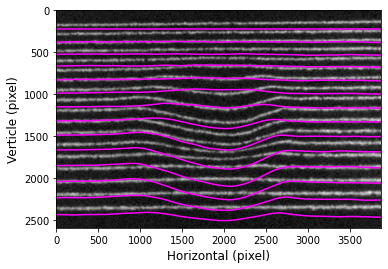

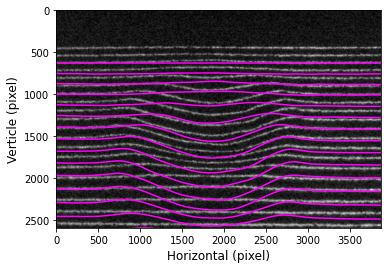

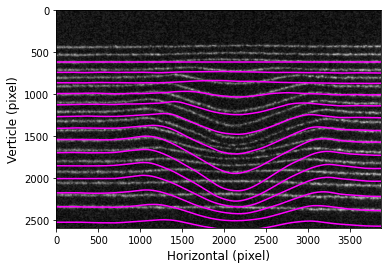

In [71]:
img_10_1 = ImportImg('DSC_9526.JPG', 9527, 9544, 18)
# img_10_2 = ImportImg('DSC_9526.JPG', 9546, 9563, 18)
# img_10_3 = ImportImg('DSC_9526.JPG', 9565, 9582, 18)

fullmap_10_1 = OverLay(img_10_1)
# fullmap_10_2 = OverLay(img_10_2)
# fullmap_10_3 = OverLay(img_10_3)

curve_fit_10_1 = CurveFit(img_10_1, fullmap_10_1)
# curve_fit_10_2 = CurveFit(img_10_2, fullmap_10_2)
# curve_fit_10_3 = CurveFit(img_10_3, fullmap_10_3)

img_45_1 = ImportImg('DSC_9463.JPG', 9464, 9483, 20)
img_80_1 = ImportImg('DSC_9602.JPG', 9603, 9620, 18)

fullmap_45_1 = OverLay(img_45_1)
fullmap_80_1 = OverLay(img_80_1)
curve_fit_45_1 = CurveFit(img_45_1, fullmap_45_1)
curve_fit_80_1 = CurveFit(img_80_1, fullmap_80_1)

In [72]:
def FindMin_index(data): # find minimum in the data set 
    tempt_value = np.zeros(np.shape(data)[0]) # store the depth value
    tempt_index = np.zeros(np.shape(data)[0]) # store the index
    for i in range(np.shape(data)[0]): # find minimum in each row 
        row_min = min(data[i][:])
        tempt_value[i] = row_min
        tempt_index[i] = data[i].index(row_min)
    row_num = tempt_value.tolist().index(min(tempt_value))
    return [row_num, tempt_index[row_num]]

In [73]:
# curve_fit = [curve_fit_10_1, curve_fit_10_2, curve_fit_10_3]
#     def Align(curve_fit):
#         col_index = np.zeros(np.shape(curve_fit)[0])
#         row_index = np.zeros(np.shape(curve_fit)[0])
#         for i in range(np.shape(curve_fit)[0]):
#             row_index[i] = FindMin_index(curve_fit[i])[0]
#             col_index[i] = FindMin_index(curve_fit[i])[1]
    

In [74]:
curves_fit_real_10_1 = ConvertToReal(curve_fit_10_1, img_10_1)[1]
curves_fit_real_45_1 = ConvertToReal(curve_fit_45_1, img_45_1)[1]
curves_fit_real_80_1 = ConvertToReal(curve_fit_80_1, img_80_1)[1]
x_real_10_1 = ConvertToReal(curve_fit_10_1, img_10_1)[0]
x_real_45_1 = ConvertToReal(curve_fit_45_1, img_45_1)[0]
x_real_80_1 = ConvertToReal(curve_fit_80_1, img_80_1)[0]

In [81]:
def plot2D(x_real, curves_fit_real, laser_line_num):
    xx = x_real*laser_line_num
    yy = []
    zz = []
    # convert three axis to 1d array / list 
    for i in range(laser_line_num):
        temp = np.linspace(0.5+i,0.5+i,len(x_real)).tolist()
        yy = yy + temp
        zz = zz + curves_fit_real[i][:]
    

    y = np.arange(0.0,laser_line_num,1)
    X, Y = np.meshgrid(x_real, y)
    z = np.array(zz)
    f = plt.figure()
    z = z.reshape(len(y), len(x_real))
    contours = plt.contour(X, Y, z, 10, colors='black', alpha = 0.9)
    levels = contours.levels
    #contours.collections[np.where(levels == 0.0)[0][0]].remove()
    clabel = plt.clabel(contours, inline=True, fontsize=8, colors='black')
    plt.imshow(z, extent=[0, max(x_real), 0, max(y)], origin='lower',cmap='RdBu', alpha=0.8,\
              aspect='auto', interpolation='bessel')
    # plot lowest point
    min_index = np.argwhere(z == z.min())[0].tolist()
    plt.plot(X[min_index[0], min_index[1]], Y[min_index[0], min_index[1]], 'x', color='yellow', label = 'center of crater')
    plt.xlabel('X (cm)', fontsize = 12)
    plt.ylabel('Y (cm)', fontsize = 12)
    plt.colorbar(label=r'Z (cm)')
    plt.savefig('contour', dpi=500, bbox_inches='tight')

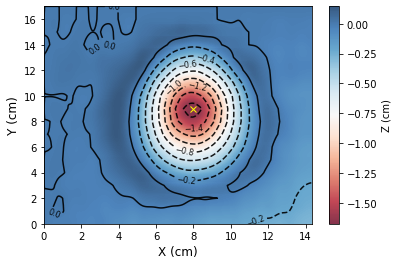

In [85]:
#plot2D(x_real_10_1, curves_fit_real_10_1, 18)
#plot2D(x_real_45_1, curves_fit_real_45_1, 18)
plot2D(x_real_80_1, curves_fit_real_80_1, 18)

In [24]:
np.shape(curves_fit_real_10_1)
np.shape(x_real_10_1)

(775,)